In [6]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [7]:
def train_test_split_random(x, Y, N_train):
    total_samples = x.shape[0]
    all_indices = np.arange(total_samples)
    
    train_indices = np.random.choice(all_indices, size=N_train, replace=False)
    test_indices = np.setdiff1d(all_indices, train_indices)
    
    train_indices = np.sort(train_indices)
    test_indices = np.sort(test_indices)
    
    x_train = x[train_indices]
    Y_train = Y[train_indices]
    x_test = x[test_indices]
    Y_test = Y[test_indices]
    
    return x_train, Y_train, x_test, Y_test

def introduce_missing_values(Y, missing_percentage):
    num_elements = Y.size
    num_nan = int(missing_percentage * num_elements)

    nan_indices = np.random.choice(num_elements, num_nan, replace=False)

    Y_flat = Y.flatten().copy()

    Y_flat[nan_indices] = np.nan

    return Y_flat.reshape(Y.shape)

def rbf_kernel(x1, x2, lengthscale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    return np.mean(nlpd_values)

# Outliers

## Simulation

Simulation and plotting

[10  4  9 10 12]


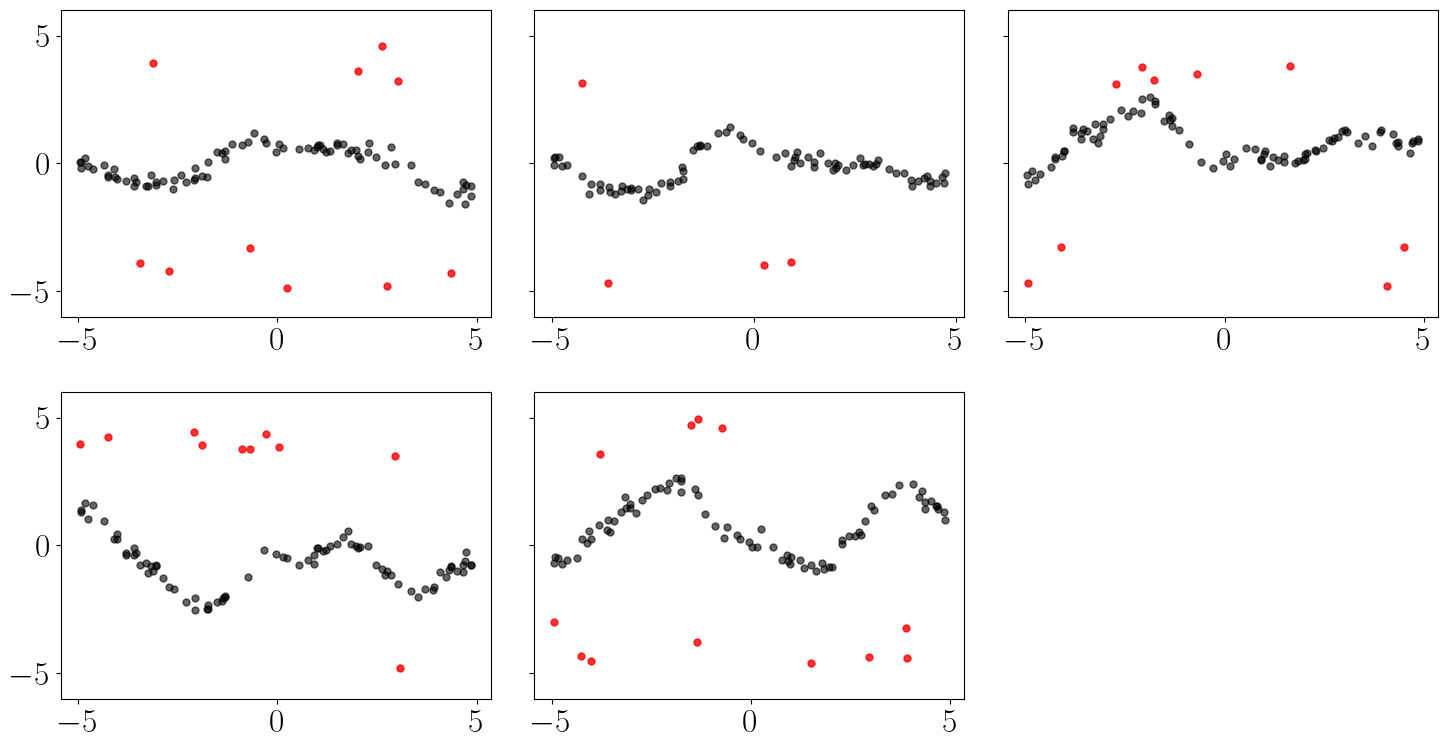

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

np.random.seed(42)
train_test_N = 300
N = 100
D = 5 
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0

x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])

A = np.linalg.cholesky(B)

Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
K = np.kron(B, Kx)

L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

f_samples = L @ np.random.randn(D*train_test_N)
F = f_samples.reshape(D, train_test_N).T
Y = F + np.random.normal(0, noise_var, F.shape)

x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
Y_train = introduce_missing_values(Y_train, missing_percentage)

num_outliers = int(epsilon * N * D * (1 - missing_percentage))
indices = np.unravel_index(np.random.choice(N * D, num_outliers, replace=False), (N, D))
uniform_outliers = np.random.uniform(0, 1, num_outliers)
outlier_values = np.where(
    uniform_outliers < 0.5,
    np.random.uniform(3, 5, num_outliers),
    np.random.uniform(-5, -3, num_outliers)
)
Y_train[indices] = outlier_values

outliers_per_channel = np.bincount(indices[1])
non_nan_counts = np.sum(~np.isnan(Y_train), axis=0)

epsilons = outliers_per_channel / non_nan_counts

print(outliers_per_channel)

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

outlier_mask = np.zeros((N, D), dtype=bool)
outlier_mask[indices] = True

for i in range(D):
    ax = axs[i // 3, i % 3]
    
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## MOGP

In [9]:
mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([noise_var] * D), A = rbf_variance*A)
mogp.fit(x_train, Y_train)

mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)

optim_noise = mogp.noise
optim_B = mogp.A @ mogp.A.T

# Predict on test points
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

## MORCGP

In [11]:
import numpy as np

# Example: assume Y_train is your numpy array
# Y_train = np.array([[1, 2], [3, np.nan], [4, 5]])

# Create a mask for rows without NaN values
mask = ~np.isnan(Y_train).any(axis=1)

# Apply the mask to keep only complete rows
Y_train_clean = Y_train[mask]

# Show how many rows are left
print(f"Rows before deletion: {Y_train.shape[0]}")
print(f"Rows after deletion:  {Y_train_clean.shape[0]}")

Rows before deletion: 100
Rows after deletion:  62


In [13]:
mcd = MinCovDet(support_fraction=0.9).fit(Y_train_clean)
robust_covariance = mcd.covariance_
empty_noise = np.array([1e-6]*D)
print(robust_covariance)

morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([noise_var]*D), A=A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, Y_train, B_weighted=robust_covariance, noise_weighted=empty_noise)

predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

[[ 1.39675795  0.38515332 -0.21934033  0.13670691 -0.49665618]
 [ 0.38515332  0.28011143 -0.19757344  0.10466648 -0.25485223]
 [-0.21934033 -0.19757344  0.76025655 -0.74814267  0.82208589]
 [ 0.13670691  0.10466648 -0.74814267  1.0243608  -0.97601581]
 [-0.49665618 -0.25485223  0.82208589 -0.97601581  1.33454966]]


## MORCGP (RCGP weights)

In [14]:
morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([noise_var]*D), A=A, epsilons=epsilons)
morcgp_pm.fit(x_train, Y_train)

morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)

mu_pm, var_pm = morcgp_pm.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp_pm.noise)

## RCGP

In [ ]:
prior_mean = ConstantMean(constant=0.0)
mu_rcgp, std_rcgp = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)

for d in range(D):
    rcgp = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=epsilon)
    rcgp.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))
    rcgp.optimize_loo_cv(print_opt_param=False, print_iter_param=False, weighted=False)
    mu_rcgp[:, d], var_rcgp = rcgp.predict(x_test)
    std_rcgp[:, d] = np.sqrt(var_rcgp + rcgp.noise)

## Combined

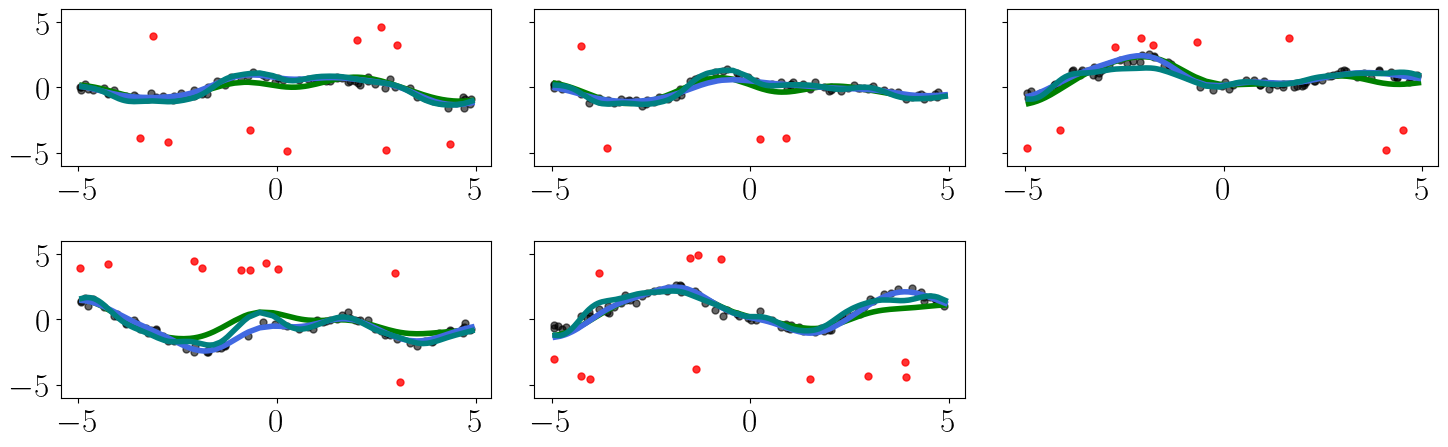

In [15]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    # MOGP
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Blue', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')

    # Predictive mean and variance
    # ax.plot(x_train.flatten(), predictive_mean[:, i], '-', color='red', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances)[:, i], predictive_mean[:, i] + np.sqrt(predictive_variances)[:, i], color='red', alpha=0.2, label=f'±2 Std. Dev.')

    # ax.plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='green', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), initial_predictive_mean[:, i] - np.sqrt(initial_predictive_variances)[:, i], initial_predictive_mean[:, i] + np.sqrt(initial_predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    # # RCGP
    # ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Orange', label=f'Predicted Mean')
    # # ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Red', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP (RCGP weights)
    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Teal', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Teal', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [16]:
rmse_mogp = calculate_rmse(Y_test, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
rmse_rcgp = calculate_rmse(Y_test, mu_rcgp)
rmse_pm = calculate_rmse(Y_test, mu_pm)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)
print("RMSE RCGP:", rmse_rcgp)
print("RMSE MORCGP (PM):", rmse_pm)

nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
nlpd_rcgp = nlpd(Y_test, mu_rcgp, std_rcgp**2)
nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)
print("NLPD RCGP:", nlpd_rcgp)
print("NLPD MORCGP (PM):", nlpd_pm)

NameError: name 'mu_rcgp' is not defined

# No outliers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

np.random.seed(42)
train_test_N = 300
N = 100
D = 5 
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1

x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])

A = np.linalg.cholesky(B)

Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
K = np.kron(B, Kx)

L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

f_samples = L @ np.random.randn(D*train_test_N)
F = f_samples.reshape(D, train_test_N).T
Y = F + np.random.normal(0, noise_var, F.shape)

x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
Y_train = introduce_missing_values(Y_train, missing_percentage)

outliers_per_channel = np.bincount(indices[1])
non_nan_counts = np.sum(~np.isnan(Y_train), axis=0)

epsilons = outliers_per_channel / non_nan_counts

print(outliers_per_channel)

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i in range(D):
    ax = axs[i // 3, i % 3]
    
    ax.plot(x_train, Y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([noise_var] * D), A = 2*A)
mogp.fit(x_train, Y_train)
mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)

optim_noise = mogp.noise
optim_B = mogp.A @ mogp.A.T

mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

In [ ]:
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([noise_var]*D), A=A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, Y_train, B_weighted=optim_B, noise_weighted=optim_noise)
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

In [ ]:
morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=[0]*D)
morcgp_pm.fit(x_train, Y_train)
morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)

mu_pm, var_pm = morcgp_pm.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp_pm.noise)

In [ ]:
prior_mean = ConstantMean(constant=0.0)

mu_rcgp, std_rcgp = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)

for d in range(D):
    rcgp = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=0)
    rcgp.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))

    rcgp.optimize_loo_cv(print_opt_param=False, print_iter_param=False, weighted=False)

    mu_rcgp[:, d], var_rcgp = rcgp.predict(x_test)
    std_rcgp[:, d] = np.sqrt(var_rcgp + rcgp.noise)

In [ ]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    ax.plot(x_train, Y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')

    # MOGP
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Blue', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')

    # Predictive mean and variance
    # ax.plot(x_train.flatten(), predictive_mean[:, i], '-', color='red', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances)[:, i], predictive_mean[:, i] + np.sqrt(predictive_variances)[:, i], color='red', alpha=0.2, label=f'±2 Std. Dev.')

    # ax.plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='green', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), initial_predictive_mean[:, i] - np.sqrt(initial_predictive_variances)[:, i], initial_predictive_mean[:, i] + np.sqrt(initial_predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    # RCGP
    ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Orange', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Red', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP (RCGP weights)
    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Teal', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Teal', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
rmse_mogp = calculate_rmse(Y_test, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
rmse_rcgp = calculate_rmse(Y_test, mu_rcgp)
rmse_pm = calculate_rmse(Y_test, mu_pm)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)
print("RMSE RCGP:", rmse_rcgp)
print("RMSE MORCGP (PM):", rmse_pm)

nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
nlpd_rcgp = nlpd(Y_test, mu_rcgp, std_rcgp**2)
nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)
print("NLPD RCGP:", nlpd_rcgp)
print("NLPD MORCGP (PM):", nlpd_pm)

# Final

In [ ]:
rmses_mogp, rmses_morcgp, rmses_rcgp, rmses_pm = [], [], [], []
nlpds_mogp, nlpds_morcgp, nlpds_rcgp, nlpds_pm = [], [], [], []

train_test_N = 300
N, D = 100, 5
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1

prior_mean = ConstantMean(constant=0.0)

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])
A = np.linalg.cholesky(B)

for i in tqdm(range(5)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)

    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)
    L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

    f_samples = L @ np.random.randn(D*train_test_N)
    F = f_samples.reshape(D, train_test_N).T
    Y = F + np.random.normal(0, noise_var, F.shape)
    Y -= np.mean(Y, axis=0)

    x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
    Y_train = introduce_missing_values(Y_train, missing_percentage)

    # MOGP
    mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([noise_var] * D), A = 2*A)
    mogp.fit(x_train, Y_train)
    mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
    optim_noise = mogp.noise
    optim_B = mogp.A @ mogp.A.T

    mu_mogp, var_mogp = mogp.predict(x_test)
    std_mogp = np.sqrt(var_mogp + mogp.noise)

    # MORCGP
    morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([noise_var]*D), A=A)
    initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, Y_train, B_weighted=optim_B, noise_weighted=optim_noise)
    predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

    mu_morcgp, var_morcgp = morcgp.predict(x_test)
    std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

    # MORCGP (RCGP weights)
    morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=[0]*D)
    morcgp_pm.fit(x_train, Y_train)
    morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)

    mu_pm, var_pm = morcgp_pm.predict(x_test)
    std_pm = np.sqrt(var_pm + morcgp_pm.noise)

    # RCGP
    mu_rcgp, std_rcgp = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)

    for d in range(D):
        rcgp = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=0)
        rcgp.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))

        rcgp.optimize_loo_cv(print_opt_param=False, print_iter_param=False, weighted=False)

        mu_rcgp[:, d], var_rcgp = rcgp.predict(x_test)
        std_rcgp[:, d] = np.sqrt(var_rcgp + rcgp.noise)

    rmse_mogp = calculate_rmse(Y_test, mu_mogp)
    rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
    rmse_rcgp = calculate_rmse(Y_test, mu_rcgp)
    rmse_pm = calculate_rmse(Y_test, mu_pm)

    # print("RMSE MOGP:", rmse_mogp)
    # print("RMSE MORCGP:", rmse_morcgp)
    # print("RMSE RCGP:", rmse_rcgp)
    # print("RMSE MORCGP (PM):", rmse_pm)

    rmses_mogp.append(rmse_mogp)
    rmses_morcgp.append(rmse_morcgp)
    rmses_rcgp.append(rmse_rcgp)
    rmses_pm.append(rmse_pm)

    nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
    nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
    nlpd_rcgp = nlpd(Y_test, mu_rcgp, std_rcgp**2)
    nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)

    # print("NLPD MOGP:", nlpd_mogp)
    # print("NLPD MORCGP:", nlpd_morcgp)
    # print("NLPD RCGP:", nlpd_rcgp)
    # print("NLPD MORCGP (PM):", nlpd_pm)

    nlpds_mogp.append(nlpd_mogp)
    nlpds_morcgp.append(nlpd_morcgp)
    nlpds_rcgp.append(nlpd_rcgp)
    nlpds_pm.append(nlpd_pm)

print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
print(f'RMSE RCGP: {np.mean(rmses_rcgp):.4f} ± {np.std(rmses_rcgp):.4f}')
print(f'RMSE MORCGP (PM): {np.mean(rmses_pm):.4f} ± {np.std(rmses_pm):.4f}')

print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
print(f'NLPD RCGP: {np.mean(nlpds_rcgp):.4f} ± {np.std(nlpds_rcgp):.4f}')
print(f'NLPD MORCGP (PM): {np.mean(nlpds_pm):.4f} ± {np.std(nlpds_pm):.4f}')

In [ ]:
print(rmses_mogp)
print(rmses_morcgp)
print(rmses_rcgp)
print(rmses_pm)

print(nlpds_mogp)
print(nlpds_morcgp)
print(nlpds_rcgp)
print(nlpds_pm)

In [ ]:
rmses_mogp_list = [x.item() for x in rmses_mogp]
rmses_morcgp_list = [x.item() for x in rmses_morcgp]
rmses_rcgp_list = [x.item() for x in rmses_rcgp]
rmses_pm_list = [x.item() for x in rmses_pm]

nlpds_mogp_list = [x.item() for x in nlpds_mogp]
nlpds_morcgp_list = [x.item() for x in nlpds_morcgp]
nlpds_rcgp_list = [x.item() for x in nlpds_rcgp]
nlpds_pm_list = [x.item() for x in nlpds_pm]

In [ ]:
print(f'RMSE MOGP: {np.mean(rmses_mogp_list):.3f} ± {np.std(rmses_mogp_list):.3f}')
print(f'RMSE MORCGP: {np.mean(rmses_morcgp_list):.3f} ± {np.std(rmses_morcgp_list):.3f}')
print(f'RMSE RCGP: {np.mean(rmses_rcgp_list):.3f} ± {np.std(rmses_rcgp_list):.3f}')
print(f'RMSE MORCGP (PM): {np.mean(rmses_pm_list):.3f} ± {np.std(rmses_pm_list):.3f}')

print(f'NLPD MOGP: {np.mean(nlpds_mogp_list):.3f} ± {np.std(nlpds_mogp_list):.3f}')
print(f'NLPD MORCGP: {np.mean(nlpds_morcgp_list):.3f} ± {np.std(nlpds_morcgp_list):.3f}')
print(f'NLPD RCGP: {np.mean(nlpds_rcgp_list):.3f} ± {np.std(nlpds_rcgp_list):.3f}')
print(f'NLPD MORCGP (PM): {np.mean(nlpds_pm_list):.3f} ± {np.std(nlpds_pm_list):.3f}')

# Final with outliers

In [ ]:
rmses_mogp_outliers, rmses_morcgp_outliers, rmses_rcgp_outliers, rmses_pm_outliers = [], [], [], []
nlpds_mogp_outliers, nlpds_morcgp_outliers, nlpds_rcgp_outliers, nlpds_pm_outliers = [], [], [], []

np.random.seed(42)
train_test_N = 300
N, D = 100, 5
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0
prior_mean = ConstantMean(constant=0.0)

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])
A = np.linalg.cholesky(B)

for i in tqdm(range(5)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    # Add a small jitter for numerical stability
    L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

    f_samples = L @ np.random.randn(D*train_test_N)
    F = f_samples.reshape(D, train_test_N).T
    Y = F + np.random.normal(0, noise_var, F.shape)

    x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
    Y_train = introduce_missing_values(Y_train, missing_percentage)

    # Add 5% outliers uniformly distributed in [-4, -2] ∪ [2, 4]
    num_outliers = int(epsilon * N * D * (1 - missing_percentage))
    # num_outliers = 0
    indices = np.unravel_index(np.random.choice(N * D, num_outliers, replace=False), (N, D))
    uniform_outliers = np.random.uniform(0, 1, num_outliers)
    outlier_values = np.where(
        uniform_outliers < 0.5,
        np.random.uniform(3, 5, num_outliers),
        np.random.uniform(-5, -3, num_outliers)
    )
    Y_train[indices] = outlier_values

    outliers_per_channel = np.bincount(indices[1])
    non_nan_counts = np.sum(~np.isnan(Y_train), axis=0)
    epsilons = outliers_per_channel / non_nan_counts

    # MOGP
    mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.2] * D), A = 2*A)
    mogp.fit(x_train, Y_train)
    mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
    optim_noise = mogp.noise
    optim_B = mogp.A @ mogp.A.T

    mu_mogp, var_mogp = mogp.predict(x_test)
    std_mogp = np.sqrt(var_mogp + mogp.noise)

    # MORCGP
    morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([0.2]*D), A=A)
    initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, Y_train, B_weighted=optim_B, noise_weighted=optim_noise)
    predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

    mu_morcgp, var_morcgp = morcgp.predict(x_test)
    std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

    # MORCGP (RCGP weights)
    morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=epsilons)
    morcgp_pm.fit(x_train, Y_train)
    morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)

    mu_pm, var_pm = morcgp_pm.predict(x_test)
    std_pm = np.sqrt(var_pm + morcgp_pm.noise)

    # RCGP
    mu_rcgp, std_rcgp = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)

    for d in range(D):
        rcgp = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=epsilon)
        rcgp.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))
        rcgp.optimize_loo_cv(print_opt_param=False, print_iter_param=False, weighted=False)
        mu_rcgp[:, d], var_rcgp = rcgp.predict(x_test)
        std_rcgp[:, d] = np.sqrt(var_rcgp + rcgp.noise)

    # Performance metrics
    rmse_mogp = calculate_rmse(Y_test, mu_mogp)
    rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
    rmse_rcgp = calculate_rmse(Y_test, mu_rcgp)
    rmse_pm = calculate_rmse(Y_test, mu_pm)

    rmses_mogp_outliers.append(rmse_mogp)
    rmses_morcgp_outliers.append(rmse_morcgp)
    rmses_rcgp_outliers.append(rmse_rcgp)
    rmses_pm_outliers.append(rmse_pm)

    nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
    nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
    nlpd_rcgp = nlpd(Y_test, mu_rcgp, std_rcgp**2)
    nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)

    nlpds_mogp_outliers.append(nlpd_mogp)
    nlpds_morcgp_outliers.append(nlpd_morcgp)
    nlpds_rcgp_outliers.append(nlpd_rcgp)
    nlpds_pm_outliers.append(nlpd_pm)

print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
print(f'RMSE RCGP: {np.mean(rmses_rcgp):.4f} ± {np.std(rmses_rcgp):.4f}')
print(f'RMSE MORCGP (PM): {np.mean(rmses_pm):.4f} ± {np.std(rmses_pm):.4f}')

print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
print(f'NLPD RCGP: {np.mean(nlpds_rcgp):.4f} ± {np.std(nlpds_rcgp):.4f}')
print(f'NLPD MORCGP (PM): {np.mean(nlpds_pm):.4f} ± {np.std(nlpds_pm):.4f}')

In [ ]:
rmses_mogp_outliers_list = [x.item() for x in rmses_mogp_outliers]
rmses_morcgp_outliers_list = [x.item() for x in rmses_morcgp_outliers]
rmses_rcgp_outliers_list = [x.item() for x in rmses_rcgp_outliers]
rmses_pm_outliers_list = [x.item() for x in rmses_pm_outliers]

nlpds_mogp_outliers_list = [x.item() for x in nlpds_mogp_outliers]
nlpds_morcgp_outliers_list = [x.item() for x in nlpds_morcgp_outliers]
nlpds_rcgp_outliers_list = [x.item() for x in nlpds_rcgp_outliers]
nlpds_pm_outliers_list = [x.item() for x in nlpds_pm_outliers]

In [ ]:
print(f'RMSE MOGP: {np.mean(rmses_mogp_outliers_list):.3f} ± {np.std(rmses_mogp_outliers_list):.3f}')
print(f'RMSE MORCGP: {np.mean(rmses_morcgp_outliers_list):.3f} ± {np.std(rmses_morcgp_outliers_list):.3f}')
print(f'RMSE RCGP: {np.mean(rmses_rcgp_outliers_list):.3f} ± {np.std(rmses_rcgp_outliers_list):.3f}')
print(f'RMSE MORCGP (PM): {np.mean(rmses_pm_outliers_list):.3f} ± {np.std(rmses_pm_outliers_list):.3f}')

print(f'NLPD MOGP: {np.mean(nlpds_mogp_outliers_list):.3f} ± {np.std(nlpds_mogp_outliers_list):.3f}')
print(f'NLPD MORCGP: {np.mean(nlpds_morcgp_outliers_list):.3f} ± {np.std(nlpds_morcgp_outliers_list):.3f}')
print(f'NLPD RCGP: {np.mean(nlpds_rcgp_outliers_list):.3f} ± {np.std(nlpds_rcgp_outliers_list):.3f}')
print(f'NLPD MORCGP (PM): {np.mean(nlpds_pm_outliers_list):.3f} ± {np.std(nlpds_pm_outliers_list):.3f}')

# Robust hyperparameter optimisation

## MORCGP

In [ ]:
rmses_weighted_outliers, rmses_unweighted_outliers = [], []
nlpds_weighted_outliers, nlpds_unweighted_outliers = [], []

train_test_N = 300
N, D = 100, 5
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])
A = np.linalg.cholesky(B)

for i in tqdm(range(1)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

    f_samples = L @ np.random.randn(D*train_test_N)
    F = f_samples.reshape(D, train_test_N).T
    Y = F + np.random.normal(0, noise_var, F.shape)

    x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
    Y_train = introduce_missing_values(Y_train, missing_percentage)

    num_outliers = int(epsilon * N * D * (1 - missing_percentage))
    uniform_outliers = np.random.uniform(0, 1, num_outliers)
    outlier_values = np.where(
        uniform_outliers < 0.5,
        np.random.uniform(3, 5, num_outliers),
        np.random.uniform(-5, -3, num_outliers)
    )
    Y_train[indices] = outlier_values

    outliers_per_channel = np.bincount(indices[1])
    non_nan_counts = np.sum(~np.isnan(Y_train), axis=0)
    epsilons = outliers_per_channel / non_nan_counts

    # MOGP
    mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.2] * D), A = 2*A)
    mogp.fit(x_train, Y_train)
    mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
    optim_noise = mogp.noise
    optim_B = mogp.A @ mogp.A.T

    # mu_mogp, var_mogp = mogp.predict(x_test)
    # std_mogp = np.sqrt(var_mogp + mogp.noise)

    # MORCGP (weighted)
    morcgp_weighted = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([0.2]*D), A=A)
    initial_predictive_mean, initial_predictive_variances = morcgp_weighted.fit(x_train, Y_train, B_weighted=optim_B, noise_weighted=optim_noise)
    morcgp_weighted.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

    mu_morcgp_weighted, var_morcgp_weighted = morcgp_weighted.predict(x_test)
    std_morcgp_weighted = np.sqrt(var_morcgp_weighted + morcgp_weighted.noise)

    # MORCGP (unweighted)
    morcgp_unweighted = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([0.2]*D), A=A)
    initial_predictive_mean, initial_predictive_variances = morcgp_unweighted.fit(x_train, Y_train, B_weighted=optim_B, noise_weighted=optim_noise)
    morcgp_unweighted.optimize_loo_cv(weighted=False, print_opt_param = False, print_iter_param=False, update_weights=True)

    mu_morcgp_unweighted, var_morcgp_unweighted = morcgp_unweighted.predict(x_test)
    std_morcgp_unweighted = np.sqrt(var_morcgp_unweighted + morcgp_unweighted.noise)

    # Performance metrics
    rmse_weighted = calculate_rmse(Y_test, mu_morcgp_weighted)
    rmse_unweighted = calculate_rmse(Y_test, mu_morcgp_unweighted)

    rmses_weighted_outliers.append(rmse_weighted)
    rmses_unweighted_outliers.append(rmse_unweighted)

    nlpd_weighted = nlpd(Y_test, mu_morcgp_weighted, std_morcgp_weighted**2)
    nlpd_unweighted = nlpd(Y_test, mu_morcgp_unweighted, std_morcgp_unweighted**2)

    nlpds_weighted_outliers.append(nlpd_weighted)
    nlpds_unweighted_outliers.append(nlpd_unweighted)

print(f'RMSE WEIGHTED (outliers): {np.mean(rmses_weighted_outliers):.4f} ± {np.std(rmses_weighted_outliers):.4f}')
print(f'RMSE UNWEIGHTED (outliers): {np.mean(rmses_unweighted_outliers):.4f} ± {np.std(rmses_unweighted_outliers):.4f}')

print(f'NLPD WEIGHTED (outliers): {np.mean(nlpds_weighted_outliers):.4f} ± {np.std(nlpds_weighted_outliers):.4f}')
print(f'NLPD UNWEIGHTED (outliers): {np.mean(nlpds_unweighted_outliers):.4f} ± {np.std(nlpds_unweighted_outliers):.4f}')

In [ ]:
rmses_weighted_no_outliers, rmses_unweighted_no_outliers = [], []
nlpds_weighted_no_outliers, nlpds_unweighted_no_outliers = [], []

train_test_N = 300
N, D = 100, 5
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])
A = np.linalg.cholesky(B)

for i in tqdm(range(5)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

    f_samples = L @ np.random.randn(D*train_test_N)
    F = f_samples.reshape(D, train_test_N).T
    Y = F + np.random.normal(0, noise_var, F.shape)

    x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
    Y_train = introduce_missing_values(Y_train, missing_percentage)

    # MOGP
    mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.2] * D), A = 2*A)
    mogp.fit(x_train, Y_train)
    mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
    optim_noise = mogp.noise
    optim_B = mogp.A @ mogp.A.T

    # MORCGP (weighted)
    morcgp_weighted = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([0.2]*D), A=A)
    initial_predictive_mean, initial_predictive_variances = morcgp_weighted.fit(x_train, Y_train, B_weighted=optim_B, noise_weighted=optim_noise)
    morcgp_weighted.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

    mu_morcgp_weighted, var_morcgp_weighted = morcgp_weighted.predict(x_test)
    std_morcgp_weighted = np.sqrt(var_morcgp_weighted + morcgp_weighted.noise)

    # MORCGP (unweighted)
    morcgp_unweighted = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([0.2]*D), A=A)
    initial_predictive_mean, initial_predictive_variances = morcgp_unweighted.fit(x_train, Y_train, B_weighted=optim_B, noise_weighted=optim_noise)
    morcgp_unweighted.optimize_loo_cv(weighted=False, print_opt_param = False, print_iter_param=False, update_weights=True)

    mu_morcgp_unweighted, var_morcgp_unweighted = morcgp_unweighted.predict(x_test)
    std_morcgp_unweighted = np.sqrt(var_morcgp_unweighted + morcgp_unweighted.noise)

    # Performance metrics
    rmse_weighted = calculate_rmse(Y_test, mu_morcgp_weighted)
    rmse_unweighted = calculate_rmse(Y_test, mu_morcgp_unweighted)

    rmses_weighted_no_outliers.append(rmse_weighted)
    rmses_unweighted_no_outliers.append(rmse_unweighted)

    nlpd_weighted = nlpd(Y_test, mu_morcgp_weighted, std_morcgp_weighted**2)
    nlpd_unweighted = nlpd(Y_test, mu_morcgp_unweighted, std_morcgp_unweighted**2)

    nlpds_weighted_no_outliers.append(nlpd_weighted)
    nlpds_unweighted_no_outliers.append(nlpd_unweighted)

print(f'RMSE WEIGHTED (no outliers): {np.mean(rmses_weighted_no_outliers):.4f} ± {np.std(rmses_weighted_no_outliers):.4f}')
print(f'RMSE UNWEIGHTED (no outliers): {np.mean(rmses_unweighted_no_outliers):.4f} ± {np.std(rmses_unweighted_no_outliers):.4f}')

print(f'NLPD WEIGHTED (no outliers): {np.mean(nlpds_weighted_no_outliers):.4f} ± {np.std(nlpds_weighted_no_outliers):.4f}')
print(f'NLPD UNWEIGHTED (no outliers): {np.mean(nlpds_unweighted_no_outliers):.4f} ± {np.std(nlpds_unweighted_no_outliers):.4f}')

## RCGP

In [ ]:
rmses_rcgp_weighted_outliers, rmses_rcgp_unweighted_outliers  = [], []
nlpds_rcgp_weighted_outliers, nlpds_rcgp_unweighted_outliers = [], []

np.random.seed(42)
train_test_N = 300
N, D = 100, 5
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0
prior_mean = ConstantMean(constant=0.0)

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])
A = np.linalg.cholesky(B)

for i in tqdm(range(4)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

    f_samples = L @ np.random.randn(D*train_test_N)
    F = f_samples.reshape(D, train_test_N).T
    Y = F + np.random.normal(0, noise_var, F.shape)

    x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
    Y_train = introduce_missing_values(Y_train, missing_percentage)

    num_outliers = int(epsilon * N * D * (1 - missing_percentage))
    indices = np.unravel_index(np.random.choice(N * D, num_outliers, replace=False), (N, D))
    uniform_outliers = np.random.uniform(0, 1, num_outliers)
    outlier_values = np.where(
        uniform_outliers < 0.5,
        np.random.uniform(3, 5, num_outliers),
        np.random.uniform(-5, -3, num_outliers)
    )
    Y_train[indices] = outlier_values

    outliers_per_channel = np.bincount(indices[1])
    non_nan_counts = np.sum(~np.isnan(Y_train), axis=0)
    epsilons = outliers_per_channel / non_nan_counts


    # RCGP weighted
    mu_rcgp_weighted, std_rcgp_weighted = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)
    for d in range(D):
        rcgp_weighted = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=epsilon)
        rcgp_weighted.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))
        rcgp_weighted.optimize_loo_cv(print_opt_param=False, print_iter_param=False, weighted=True)
        mu_rcgp_weighted[:, d], var_rcgp_weighted = rcgp_weighted.predict(x_test)
        std_rcgp_weighted[:, d] = np.sqrt(var_rcgp_weighted + rcgp_weighted.noise)

    # RCGP unweighted
    mu_rcgp_unweighted, std_rcgp_unweighted = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)
    for d in range(D):
        rcgp_unweighted = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=epsilon)
        rcgp_unweighted.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))
        rcgp_unweighted.optimize_loo_cv(print_opt_param=False, print_iter_param=False, weighted=False)
        mu_rcgp_unweighted[:, d], var_rcgp_unweighted = rcgp_unweighted.predict(x_test)
        std_rcgp_unweighted[:, d] = np.sqrt(var_rcgp_unweighted + rcgp_unweighted.noise)

    # Performance metrics
    rmse_rcgp_weighted = calculate_rmse(Y_test, mu_rcgp_weighted)
    rmse_rcgp_unweighted = calculate_rmse(Y_test, mu_rcgp_unweighted)

    rmses_rcgp_weighted_outliers.append(rmse_rcgp_weighted)
    rmses_rcgp_unweighted_outliers.append(rmse_rcgp_unweighted)

    nlpd_rcgp_weighted = nlpd(Y_test, mu_rcgp_weighted, std_rcgp_weighted**2)
    nlpd_rcgp_unweighted = nlpd(Y_test, mu_rcgp_unweighted, std_rcgp_unweighted**2)

    nlpds_rcgp_weighted_outliers.append(nlpd_rcgp_weighted)
    nlpds_rcgp_unweighted_outliers.append(nlpd_rcgp_unweighted)


print(f'RMSE WEIGHTED RCGP (outliers): {np.mean(rmses_rcgp_weighted_outliers):.4f} ± {np.std(rmses_rcgp_weighted_outliers):.4f}')
print(f'RMSE UNWEIGHTED RCGP (outliers): {np.mean(rmses_rcgp_unweighted_outliers):.4f} ± {np.std(rmses_rcgp_unweighted_outliers):.4f}')

print(f'NLPD WEIGHTED RCGP (outliers): {np.mean(nlpds_rcgp_weighted_outliers):.4f} ± {np.std(nlpds_rcgp_weighted_outliers):.4f}')
print(f'NLPD UNWEIGHTED RCGP (outliers): {np.mean(nlpds_rcgp_unweighted_outliers):.4f} ± {np.std(nlpds_rcgp_unweighted_outliers):.4f}')

In [ ]:
rmses_rcgp_weighted_no_outliers, rmses_rcgp_unweighted_no_outliers  = [], []
nlpds_rcgp_weighted_no_outliers, nlpds_rcgp_unweighted_no_outliers = [], []

np.random.seed(42)
train_test_N = 300
N, D = 100, 5
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0
prior_mean = ConstantMean(constant=0.0)

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])
A = np.linalg.cholesky(B)

for i in tqdm(range(4)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

    f_samples = L @ np.random.randn(D*train_test_N)
    F = f_samples.reshape(D, train_test_N).T
    Y = F + np.random.normal(0, noise_var, F.shape)

    x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
    Y_train = introduce_missing_values(Y_train, missing_percentage)

    # RCGP weighted
    mu_rcgp_weighted, std_rcgp_weighted = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)
    for d in range(D):
        rcgp_weighted = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=epsilon)
        rcgp_weighted.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))
        rcgp_weighted.optimize_loo_cv(print_opt_param=False, print_iter_param=False, weighted=True)
        mu_rcgp_weighted[:, d], var_rcgp_weighted = rcgp_weighted.predict(x_test)
        std_rcgp_weighted[:, d] = np.sqrt(var_rcgp_weighted + rcgp_weighted.noise)

    # RCGP unweighted
    mu_rcgp_unweighted, std_rcgp_unweighted = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)
    for d in range(D):
        rcgp_unweighted = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=epsilon)
        rcgp_unweighted.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))
        rcgp_unweighted.optimize_loo_cv(print_opt_param=False, print_iter_param=False, weighted=False)
        mu_rcgp_unweighted[:, d], var_rcgp_unweighted = rcgp_unweighted.predict(x_test)
        std_rcgp_unweighted[:, d] = np.sqrt(var_rcgp_unweighted + rcgp_unweighted.noise)

    # Performance metrics
    rmse_rcgp_weighted = calculate_rmse(Y_test, mu_rcgp_weighted)
    rmse_rcgp_unweighted = calculate_rmse(Y_test, mu_rcgp_unweighted)

    rmses_rcgp_weighted_no_outliers.append(rmse_rcgp_weighted)
    rmses_rcgp_unweighted_no_outliers.append(rmse_rcgp_unweighted)

    nlpd_rcgp_weighted = nlpd(Y_test, mu_rcgp_weighted, std_rcgp_weighted**2)
    nlpd_rcgp_unweighted = nlpd(Y_test, mu_rcgp_unweighted, std_rcgp_unweighted**2)

    nlpds_rcgp_weighted_no_outliers.append(nlpd_rcgp_weighted)
    nlpds_rcgp_unweighted_no_outliers.append(nlpd_rcgp_unweighted)


print(f'RMSE WEIGHTED RCGP (outliers): {np.mean(rmses_rcgp_weighted_no_outliers):.4f} ± {np.std(rmses_rcgp_weighted_no_outliers):.4f}')
print(f'RMSE UNWEIGHTED RCGP (outliers): {np.mean(rmses_rcgp_unweighted_no_outliers):.4f} ± {np.std(rmses_rcgp_unweighted_no_outliers):.4f}')

print(f'NLPD WEIGHTED RCGP (outliers): {np.mean(nlpds_rcgp_weighted_no_outliers):.4f} ± {np.std(nlpds_rcgp_weighted_no_outliers):.4f}')
print(f'NLPD UNWEIGHTED RCGP (outliers): {np.mean(nlpds_rcgp_unweighted_no_outliers):.4f} ± {np.std(nlpds_rcgp_unweighted_no_outliers):.4f}')

## MORCGP (RCGP weights)

In [ ]:
rmses_pm_weighted_outliers, rmses_pm_unweighted_outliers= [], []
nlpds_pm_weighted_outliers, nlpds_pm_unweighted_outliers = [], []

np.random.seed(42)
train_test_N = 300
N, D = 100, 5
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0
prior_mean = ConstantMean(constant=0.0)

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])
A = np.linalg.cholesky(B)

for i in tqdm(range(5)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

    f_samples = L @ np.random.randn(D*train_test_N)
    F = f_samples.reshape(D, train_test_N).T
    Y = F + np.random.normal(0, noise_var, F.shape)

    x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
    Y_train = introduce_missing_values(Y_train, missing_percentage)

    num_outliers = int(epsilon * N * D * (1 - missing_percentage))
    indices = np.unravel_index(np.random.choice(N * D, num_outliers, replace=False), (N, D))
    uniform_outliers = np.random.uniform(0, 1, num_outliers)
    outlier_values = np.where(
        uniform_outliers < 0.5,
        np.random.uniform(3, 5, num_outliers),
        np.random.uniform(-5, -3, num_outliers)
    )
    Y_train[indices] = outlier_values

    outliers_per_channel = np.bincount(indices[1])
    non_nan_counts = np.sum(~np.isnan(Y_train), axis=0)
    epsilons = outliers_per_channel / non_nan_counts

    # # Weighted MORCGP (RCGP weights)
    # morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=epsilons)
    # morcgp_pm.fit(x_train, Y_train)
    # morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)

    # mu_pm, var_pm = morcgp_pm.predict(x_test)
    # std_pm = np.sqrt(var_pm + morcgp_pm.noise)

    # Unweighted MORCGP (RCGP weights)
    morcgp_pm_unweighted = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=epsilons)
    morcgp_pm_unweighted.fit(x_train, Y_train)
    morcgp_pm_unweighted.optimize_loo_cv(weighted=False, print_opt_param = False, print_iter_param=False)

    mu_pm_unweighted, var_pm_unweighted = morcgp_pm_unweighted.predict(x_test)
    std_pm_unweighted = np.sqrt(var_pm_unweighted + morcgp_pm_unweighted.noise)

    # Performance metrics
    rmse_pm_unweighted = calculate_rmse(Y_test, mu_pm_unweighted)
    rmses_pm_unweighted_outliers.append(rmse_pm_unweighted)

    nlpd_pm_unweighted = nlpd(Y_test, mu_pm_unweighted, std_pm_unweighted**2)
    nlpds_pm_unweighted_outliers.append(nlpd_pm_unweighted)

print(f'RMSE MORCGP unweighted (PM): {np.mean(rmses_pm_unweighted_outliers):.4f} ± {np.std(rmses_pm_unweighted_outliers):.4f}')
print(f'NLPD MORCGP unweighted (PM): {np.mean(nlpds_pm_unweighted_outliers):.4f} ± {np.std(nlpds_pm_unweighted_outliers):.4f}')

In [ ]:
rmses_pm_weighted_no_outliers, rmses_pm_unweighted_no_outliers= [], []
nlpds_pm_weighted_no_outliers, nlpds_pm_unweighted_no_outliers = [], []

np.random.seed(42)
train_test_N = 300
N, D = 100, 5
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0
prior_mean = ConstantMean(constant=0.0)

B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])
A = np.linalg.cholesky(B)

for i in tqdm(range(5)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

    f_samples = L @ np.random.randn(D*train_test_N)
    F = f_samples.reshape(D, train_test_N).T
    Y = F + np.random.normal(0, noise_var, F.shape)

    x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
    Y_train = introduce_missing_values(Y_train, missing_percentage)

    # # Weighted MORCGP (RCGP weights)
    # morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=epsilons)
    # morcgp_pm.fit(x_train, Y_train)
    # morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)

    # mu_pm, var_pm = morcgp_pm.predict(x_test)
    # std_pm = np.sqrt(var_pm + morcgp_pm.noise)

    # Unweighted MORCGP (RCGP weights)
    morcgp_pm_unweighted = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=np.array([0]*D))
    morcgp_pm_unweighted.fit(x_train, Y_train)
    morcgp_pm_unweighted.optimize_loo_cv(weighted=False, print_opt_param = False, print_iter_param=False)

    mu_pm_unweighted, var_pm_unweighted = morcgp_pm_unweighted.predict(x_test)
    std_pm_unweighted = np.sqrt(var_pm_unweighted + morcgp_pm_unweighted.noise)

    # Performance metrics
    rmse_pm_unweighted = calculate_rmse(Y_test, mu_pm_unweighted)
    rmses_pm_unweighted_no_outliers.append(rmse_pm_unweighted)

    nlpd_pm_unweighted = nlpd(Y_test, mu_pm_unweighted, std_pm_unweighted**2)
    nlpds_pm_unweighted_no_outliers.append(nlpd_pm_unweighted)

print(f'RMSE MORCGP unweighted (PM): {np.mean(rmses_pm_unweighted_no_outliers):.4f} ± {np.std(rmses_pm_unweighted_no_outliers):.4f}')
print(f'NLPD MORCGP unweighted (PM): {np.mean(nlpds_pm_unweighted_no_outliers):.4f} ± {np.std(nlpds_pm_unweighted_no_outliers):.4f}')